# Portfolio Optimization using Monte Carlo Simulation

## Introduction
This document outlines the steps and methodologies employed in the analysis of stock price data for the purpose of optimizing an investment portfolio using Monte Carlo simulation techniques. The objective is to find the optimal portfolio by exploring the Sharpe Ratio and the cVaR metric.

## Importation

In [2]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/d5/b5/70bb98ee38ce532ee29fab76fb668382291fe6e1aa69a8c1ac7e6bc108e7/yfinance-0.2.38-py2.py3-none-any.whl.metadata
  Obtaining dependency information for multitasking>=0.0.7 from https://files.pythonhosted.org/packages/3e/8a/bb3160e76e844db9e69a413f055818969c8acade64e1a9ac5ce9dfdcf6c1/multitasking-0.0.11-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/315.3 kB ? eta -:--:--
     - -------------------------------------- 10.2/315.3 kB ? eta -:--:--
     - -------------------------------------- 10.2/315.3 kB ? eta -:--:--
     ---- -------------------------------- 41.0/315.3 kB 330.3 kB/s eta 0:00:01
     ---- -------------------------------- 41.0/315.3 kB 330.3 kB/s eta 0:00:01
     ---- -------------------------------- 41.0/315.3 kB 330.3 kB/s eta 0:00:01
     ---- ----------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import skew, kurtosis, skewtest, kurtosistest,shapiro
import yfinance as yf

## Data Collection, Preparation and Visualization 
Data for stocks including AAPL, GOOGL, MSFT, AMZN, and TSLA were collected over a period from January 2012 to January 2024 using the Yahoo Finance API via the yfinance package.

In [22]:
# Step 1: Data Import
stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN','TSLA']
data = yf.download(stocks, start="2012-01-01", end="2024-01-01")['Adj Close']



[*********************100%%**********************]  5 of 5 completed


In [25]:
data.head()


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2012-01-03,12.433824,8.9515,16.651901,21.238758,1.872000
2012-01-04,12.500646,8.8755,16.723724,21.738585,1.847333
2012-01-05,12.639424,8.8805,16.491741,21.960730,1.808000
2012-01-06,12.771559,9.1305,16.266768,22.301882,1.794000
2012-01-09,12.751300,8.9280,15.577077,22.008335,1.816667


In [26]:
data = data.dropna()  


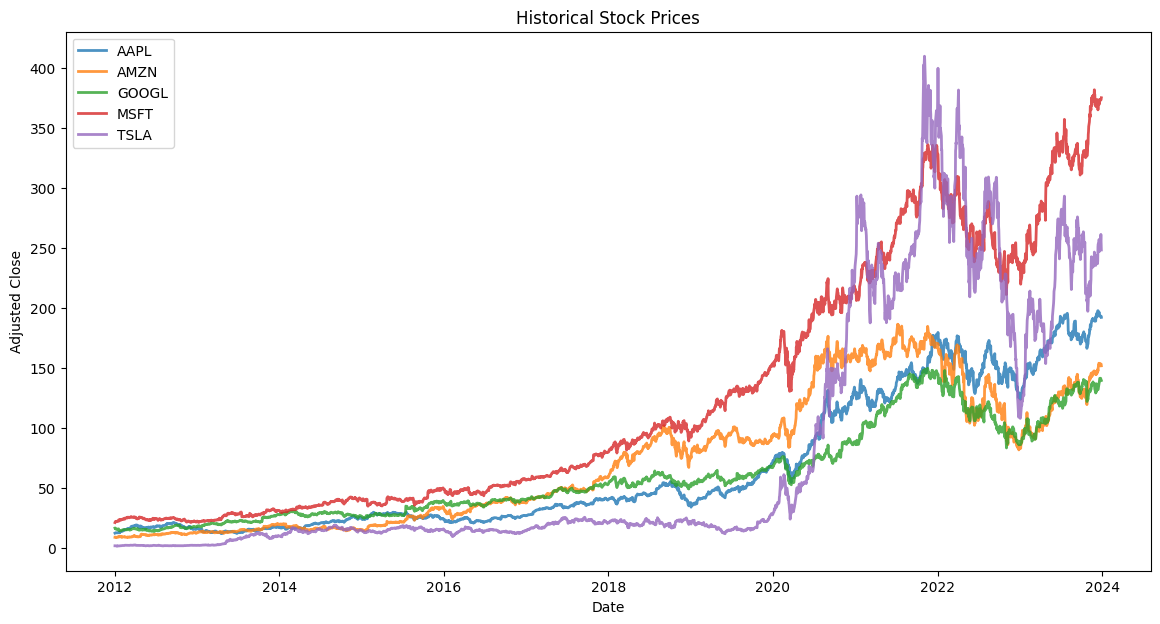

In [24]:
plt.figure(figsize=(14, 7))
for c in data.columns.values:
    plt.plot(data.index, data[c], lw=2, alpha=0.8,label=c)
plt.title('Historical Stock Prices')
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.legend()
plt.show()

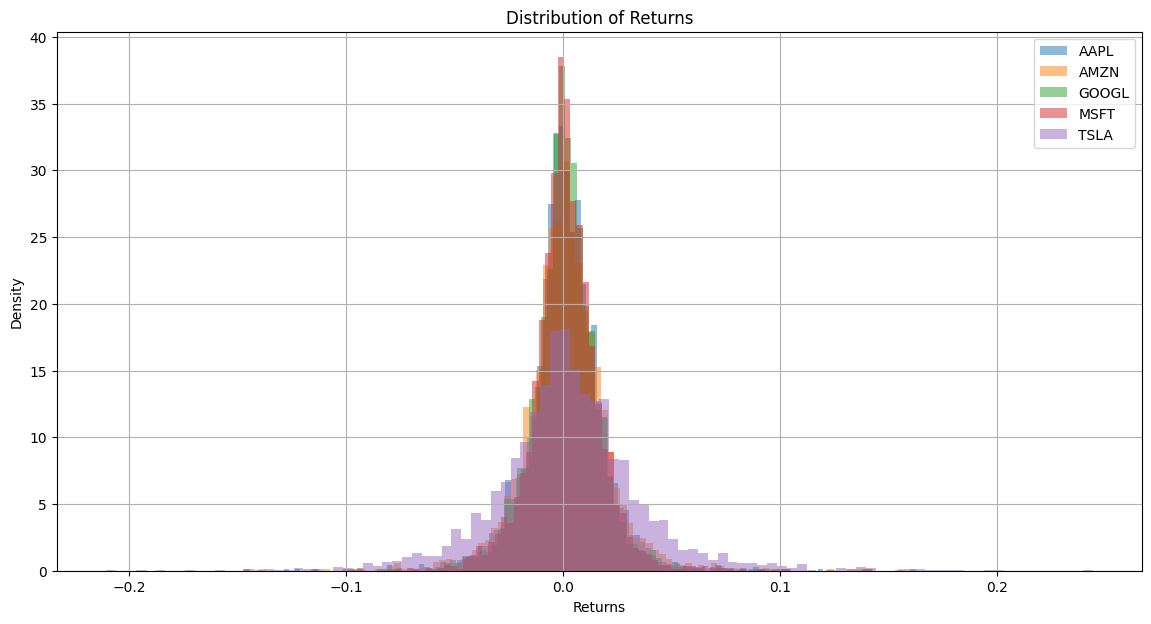

In [30]:
# Plotting the distribution of returns
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    # Plot histogram with 100 bins and normalization
    plt.hist(returns[c], bins=100, alpha=0.5, label=c, density=True)

plt.title('Distribution of Returns')
plt.xlabel('Returns')
plt.ylabel('Density')  # Changed from 'Frequency' to 'Density' for better understanding
plt.legend()
plt.grid(True)
plt.show()

In [64]:
def pct_plot(data):
    fig = plt.figure(figsize=(12,12))
    for i, column in enumerate(data.columns):
        plt.subplot(4,2,i+1)
        plt.plot(np.log(1 + data[column].pct_change()), color='r')
        plt.xticks(size=10)
        plt.title(column)
    
    fig.tight_layout()
    plt.show()

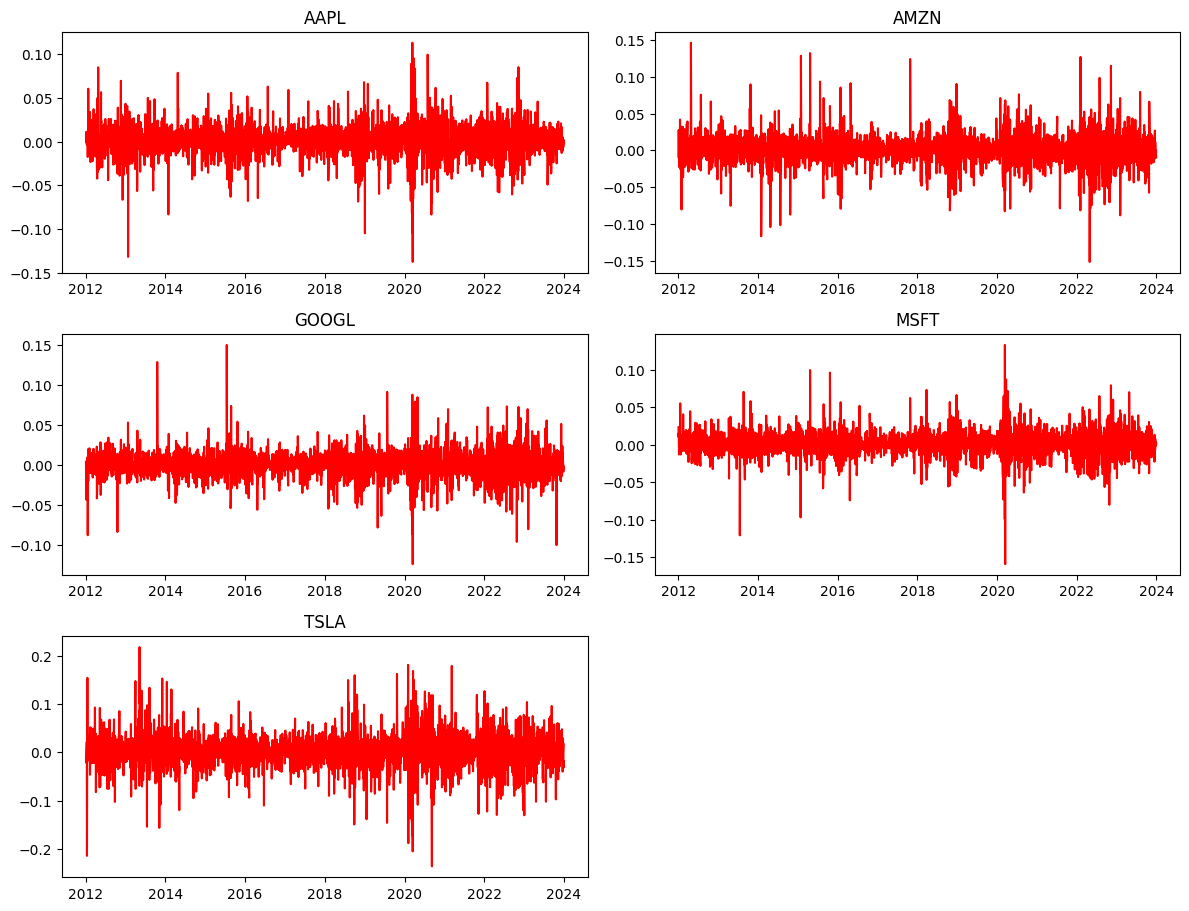

In [65]:
pct_plot(data)

## Statistics Analysis
Descriptive statistics were computed to summarize the data, providing insights into the mean, standard deviation, and other statistical measures of the adjusted close prices. Additionally, percentage changes (pct_change()) were calculated to understand daily returns, which serve as the basis for further financial analysis.

In [27]:
print(data.describe())  


Ticker         AAPL         AMZN        GOOGL         MSFT         TSLA
count   3018.000000  3018.000000  3018.000000  3018.000000  3018.000000
mean      65.931802    72.523247    60.830752   124.683836    79.178199
std       56.337633    53.956645    38.315934   103.442898   104.535965
min       11.982237     8.796500    13.990240    21.238758     1.519333
25%       22.420420    18.760625    28.545203    38.673099    13.818667
50%       39.241976    59.735750    51.987249    80.267258    18.954333
75%      121.404325   114.268002    88.011623   215.919777   159.730003
max      197.857529   186.570496   149.838501   381.993622   409.970001


In [29]:
returns = data.pct_change().dropna()
print(returns.describe())

Ticker         AAPL         AMZN        GOOGL         MSFT         TSLA
count   3017.000000  3017.000000  3017.000000  3017.000000  3017.000000
mean       0.001069     0.001148     0.000850     0.001091     0.002254
std        0.017940     0.020518     0.017030     0.016639     0.035660
min       -0.128647    -0.140494    -0.116341    -0.147391    -0.210628
25%       -0.007410    -0.008796    -0.007080    -0.006728    -0.015093
50%        0.000888     0.000955     0.000775     0.000699     0.001354
75%        0.010349     0.011568     0.009209     0.009428     0.019124
max        0.119808     0.157457     0.162584     0.142169     0.243951


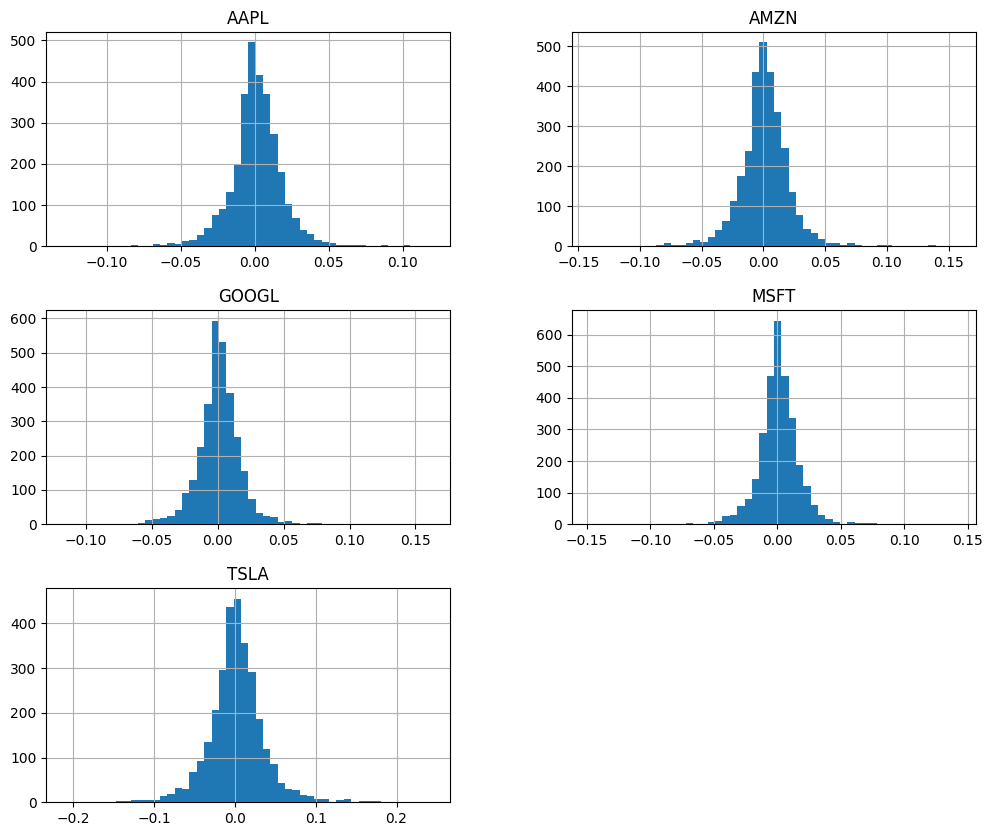

In [71]:
# Plot histograms of returns
returns.hist(bins=50, figsize=(12, 10))
plt.show()

In [60]:
def normality_test(df):
    # Initialize DataFrame to hold results
    results = pd.DataFrame(index=df.columns, columns=['Shapiro-Wilk Stat', 'P-value'])

    # Shapiro-Wilk Test for each column in the DataFrame
    for column in df.columns:
        stat, p_value = shapiro(df[column])
        results.loc[column] = [stat, p_value]

    # Display results
    print('\n' + '='*75)
    print('SHAPIRO-WILK TEST RESULTS: Under H0 "The distribution is normal"')
    print('-'*75)
    print(results.round(3))
    print('-'*75)

 

In [61]:
normality_test(data)


SHAPIRO-WILK TEST RESULTS: Under H0 "The distribution is normal"
---------------------------------------------------------------------------
       Shapiro-Wilk Stat P-value
Ticker                          
AAPL            0.801819     0.0
AMZN            0.892294     0.0
GOOGL           0.891157     0.0
MSFT            0.845513     0.0
TSLA            0.701899     0.0
---------------------------------------------------------------------------


All p-values are 0.0, which is significantly below the typical threshold of 0.05 used to reject the null hypothesis. This strongly suggests that the return distributions for AAPL, AMZN, GOOGL, MSFT, and TSLA are not normally distributed.

## Portfolio Simulation
Using Monte Carlo simulation, we randomly generated portfolio weights over 10,000 simulations to analyze different portfolio configurations. This method allows us to assess potential future performance without assuming any specific theoretical distribution.

- Returns: Expected annual returns of the portfolio.
- Volatility: Annualized standard deviation of the portfolio returns, representing the risk.
- Sharpe Ratio: Measures the performance of the investment compared to a risk-free asset, after adjusting for its risk. It is calculated as the difference between the returns of the investment and the risk-free rate, divided by the standard deviation of the investment returns. A higher Sharpe Ratio indicates a more desirable result (i.e., higher return per unit of risk).

In [42]:

# Set the seed for reproducibility
np.random.seed(0)

# Define the number of portfolios to simulate
nb_portfolio = 10000


In [44]:
log_return = np.log(1 + data.pct_change())


In [45]:
# Initialize matrices to store the simulation results
all_weights = np.zeros((nb_portfolio, len(data.columns)))
ret_arr = np.zeros(nb_portfolio)
vol_arr = np.zeros(nb_portfolio)
sharpe_arr = np.zeros(nb_portfolio)


Weight: [Stock]: Represents the proportion of the total portfolio value that is invested in each stock. The weights across each stock in a single row sum to 1.

In [ ]:

# Begin simulations
for ind in range(nb_portfolio):
    # Generate random weights and normalize them
    weights = np.random.random(len(data.columns))
    weights /= np.sum(weights)
    all_weights[ind, :] = weights.round(3)

    # Expected portfolio return
    ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)

    # Expected portfolio volatility
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))

    # Sharpe ratio
    sharpe_arr[ind] = ret_arr[ind] / vol_arr[ind]

# Create a DataFrame to hold the simulation results
simulations_df = pd.DataFrame({
    'Returns': ret_arr,
    'Volatility': vol_arr,
    'Sharpe Ratio': sharpe_arr
})

# Append weights to the DataFrame
for i, stock in enumerate(stocks):
    simulations_df[f'Weight: {stock}'] = all_weights[:, i]

# Display the results
print('\n' + '=' * 75)
print('SIMULATIONS RESULT:')
print('-' * 75)
print(simulations_df.head())
print('-' * 75)



###  Find the portfolios with the highest Sharpe Ratio and Min Volatility


In [48]:
max_sharpe_idx = sharpe_arr.argmax()
optimal_weights = all_weights[max_sharpe_idx]
print(f"Optimal Portfolio Weights: {dict(zip(stocks, optimal_weights.round(3)))}")
print(f"Maximum Sharpe Ratio: {sharpe_arr[max_sharpe_idx]:.3f}")


Optimal Portfolio Weights: {'AAPL': 0.227, 'GOOGL': 0.195, 'MSFT': 0.007, 'AMZN': 0.414, 'TSLA': 0.157}
Maximum Sharpe Ratio: 1.035


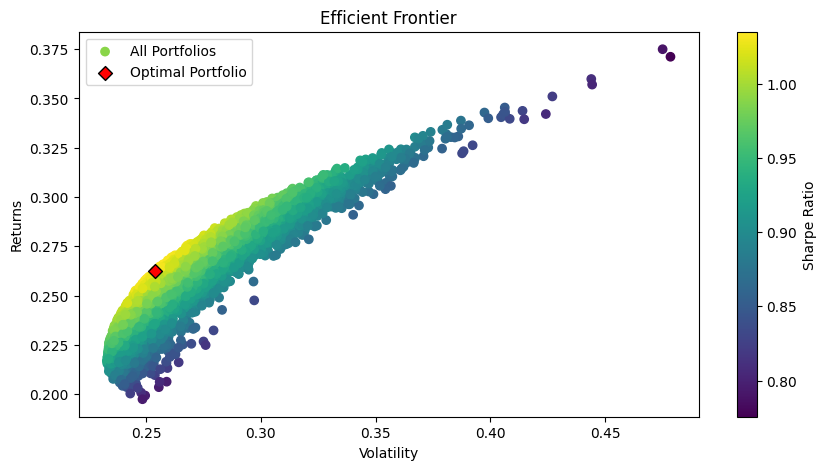

In [50]:
plt.figure(figsize=(10, 5))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', label='All Portfolios')
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Returns')

# Adding a marker for the optimal portfolio
optimal_volatility = vol_arr[max_sharpe_idx]
optimal_return = ret_arr[max_sharpe_idx]
plt.scatter(optimal_volatility, optimal_return, color='red', s=50, edgecolors='black', label='Optimal Portfolio', marker='D')  # 'D' stands for diamond shape

# Add legend to distinguish the optimal portfolio
plt.legend()

plt.show()


MAX SHARPE RATIO
***********************************
Returns          0.262693
Volatility       0.253790
Sharpe Ratio     1.035079
Weight: AAPL     0.227000
Weight: GOOGL    0.195000
Weight: MSFT     0.007000
Weight: AMZN     0.414000
Weight: TSLA     0.157000
Name: 8562, dtype: float64
***********************************
Optimal Allocation:
AAPL     0.227
GOOGL    0.195
MSFT     0.007
AMZN     0.414
TSLA     0.157
Name: 8562, dtype: float64
-----------------------------------

MIN VOLATILITY
***********************************
Returns          0.217011
Volatility       0.232827
Sharpe Ratio     0.932068
Weight: AAPL     0.238000
Weight: GOOGL    0.089000
Weight: MSFT     0.323000
Weight: AMZN     0.348000
Weight: TSLA     0.001000
Name: 8194, dtype: float64
***********************************
Optimal Allocation:
AAPL     0.238
GOOGL    0.089
MSFT     0.323
AMZN     0.348
TSLA     0.001
Name: 8194, dtype: float64
-----------------------------------


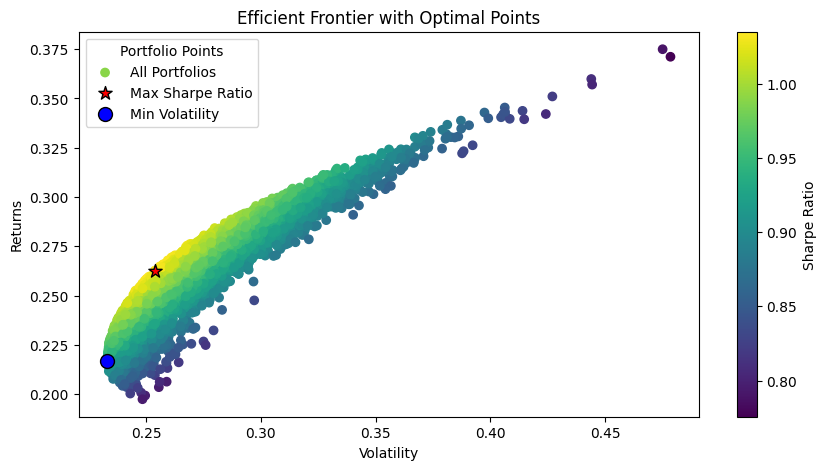

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


allocation = pd.DataFrame(all_weights, columns=['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA'])

# Find the index of the max Sharpe Ratio and min Volatility
max_sharpe_idx = simulations_df['Sharpe Ratio'].idxmax()
min_volatility_idx = simulations_df['Volatility'].idxmin()

# Extract data for the Max Sharpe Ratio and Min Volatility
max_sharpe_ratio = simulations_df.loc[max_sharpe_idx]
min_volatility = simulations_df.loc[min_volatility_idx]

# Extract allocation details for both scenarios
alloc_max_sr = allocation.loc[max_sharpe_idx]
alloc_min_vol = allocation.loc[min_volatility_idx]

# Print Max Sharpe Ratio details
print('\n' + '=' * 35)
print('MAX SHARPE RATIO')
print('*' * 35)
print(max_sharpe_ratio)
print('*' * 35)
print("Optimal Allocation:")
print(alloc_max_sr)
print('-' * 35)

# Print Min Volatility details
print('\n' + '=' * 35)
print('MIN VOLATILITY')
print('*' * 35)
print(min_volatility)
print('*' * 35)
print("Optimal Allocation:")
print(alloc_min_vol)
print('-' * 35)

# Enhance visualization to include markers for both maximum Sharpe Ratio and minimum Volatility
plt.figure(figsize=(10, 5))
plt.scatter(simulations_df['Volatility'], simulations_df['Returns'], c=simulations_df['Sharpe Ratio'], cmap='viridis', label='All Portfolios')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe_ratio['Volatility'], max_sharpe_ratio['Returns'], color='red', s=100, edgecolors='black', label='Max Sharpe Ratio', marker='*')
plt.scatter(min_volatility['Volatility'], min_volatility['Returns'], color='blue', s=100, edgecolors='black', label='Min Volatility', marker='o')
plt.title('Efficient Frontier with Optimal Points')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.legend(title='Portfolio Points')
plt.show()


## Portfolio Optimization with Conditional Value at Risk (CVaR)


The CVaR optimization focuses on minimizing the expected loss exceeding the Value at Risk (VaR). It is particularly useful for investors who are concerned about the potential for extreme loss.

- Value at Risk (VaR): This measures the maximum loss expected (or worst-case scenario) over a target horizon within a given confidence interval (typically 95% or 99%).
- Conditional Value at Risk (CVaR): Also known as Expected Shortfall, CVaR measures the average loss exceeding the VaR level within a given confidence interval.



Portfolio with Minimum CVaR:
Returns          0.217872
Volatility       0.233583
Sharpe Ratio     0.932740
Weight: AAPL     0.236000
Weight: GOOGL    0.028000
Weight: MSFT     0.314000
Weight: AMZN     0.421000
Weight: TSLA     0.001000
VaR              0.022700
CVaR             0.034214
Name: 9808, dtype: float64


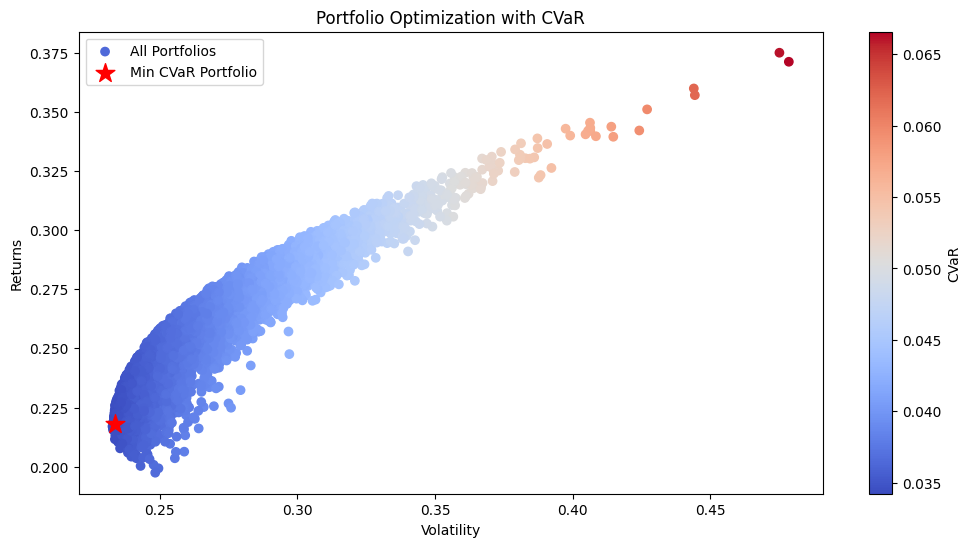

In [52]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# Assuming 'returns' and 'all_weights' are defined and contain historical return data and portfolio weights respectively
# Define the confidence level
confidence_level = 0.05

# Initialize arrays to store VaR and CVaR
VaR_arr = np.zeros(nb_portfolio)
CVaR_arr = np.zeros(nb_portfolio)

# Calculate VaR and CVaR for each portfolio
for ind in range(nb_portfolio):
    # Select the portfolio weights for this iteration
    weights = all_weights[ind]
    
    # Calculate portfolio returns
    portfolio_returns = np.sum(returns * weights, axis=1)
    
    # Sort the returns for VaR and CVaR calculation
    sorted_returns = np.sort(portfolio_returns)
    
    # Calculate VaR
    VaR_index = int(confidence_level * len(sorted_returns))
    VaR_arr[ind] = -sorted_returns[VaR_index]  # Negative sign because VaR is typically expressed as a positive number
    
    # Calculate CVaR
    CVaR_arr[ind] = -np.mean(sorted_returns[:VaR_index])  # Negative sign for the same reason

# Adding VaR and CVaR to the simulations DataFrame
simulations_df['VaR'] = VaR_arr
simulations_df['CVaR'] = CVaR_arr

# Find the portfolio with the minimum CVaR
min_cvar_idx = simulations_df['CVaR'].idxmin()
min_cvar_portfolio = simulations_df.loc[min_cvar_idx]

# Print the details for the portfolio with the minimum CVaR
print("\nPortfolio with Minimum CVaR:")
print(min_cvar_portfolio)

# Enhance visualization - plotting VaR and CVaR
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(simulations_df['Volatility'], simulations_df['Returns'], c=simulations_df['CVaR'], cmap='coolwarm', label='All Portfolios')
plt.colorbar(label='CVaR')
plt.scatter(min_cvar_portfolio['Volatility'], min_cvar_portfolio['Returns'], color='red', marker='*', s=200, label='Min CVaR Portfolio')
plt.title('Portfolio Optimization with CVaR')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.legend()
plt.show()


- Red Star: Represents the portfolio with the Minimum CVaR, indicating the optimal choice for minimizing losses in the worst-case scenarios.
- Color Gradient (Blue to Red): Shows portfolios with increasing CVaR values. Darker reds signify higher risk of extreme loss

## References : 
- https://medium.com/@beingamanforever/portfolio-optimisation-using-monte-carlo-simulation-25d88003782e
- https://medium.com/@indubarnwal752/user-friendly-portfolio-optimization-using-mcs-5154ff52dc14